# Generating Star Trek Titles with an RNN

- Trains on Star Trek episode titles
- Outputs "fake" titles.
- Uses the "charRNN" idea.

Much comes from a [Keras example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py).

## Setup Environment

- Import Keras
- Open up the Star Trek corpus
- We need to translate the textual data into a format that the RNN can accept as input.
- Give each letter an index and create dictionaries to translate from index to character.

In [1]:
## Much borrowed from https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model

from keras.callbacks import LambdaCallback
import numpy as np
import random
import sys

text = open("../datasets/startrekepisodes.txt").read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
vocabulary_size = len(chars)
print('total chars:', vocabulary_size)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


# How long is a title?
titles = text.split('\n')
lengths = np.array([len(n) for n in titles])
print("Max:", np.max(lengths))
print("Mean:", np.mean(lengths))
print("Median:", np.median(lengths))
print("Min:", np.min(lengths))
print()

# hence choose 30 as seuence length to train on.
print("Character Dictionary: ", char_indices)
print()
print("Inverse Character Dictionary: ", indices_char)

Using TensorFlow backend.


corpus length: 11010
total chars: 49
Max: 50
Mean: 14.001362397820163
Median: 13.0
Min: 2

Character Dictionary:  {'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '7': 15, '8': 16, '9': 17, ':': 18, '?': 19, 'a': 20, 'b': 21, 'c': 22, 'd': 23, 'e': 24, 'f': 25, 'g': 26, 'h': 27, 'i': 28, 'j': 29, 'k': 30, 'l': 31, 'm': 32, 'n': 33, 'o': 34, 'p': 35, 'q': 36, 'r': 37, 's': 38, 't': 39, 'u': 40, 'v': 41, 'w': 42, 'x': 43, 'y': 44, 'z': 45, 'à': 46, 'é': 47, '’': 48}

Inverse Character Dictionary:  {0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: '0', 10: '1', 11: '2', 12: '3', 13: '4', 14: '5', 15: '7', 16: '8', 17: '9', 18: ':', 19: '?', 20: 'a', 21: 'b', 22: 'c', 23: 'd', 24: 'e', 25: 'f', 26: 'g', 27: 'h', 28: 'i', 29: 'j', 30: 'k', 31: 'l', 32: 'm', 33: 'n', 34: 'o', 35: 'p', 36: 'q', 37: 'r', 38: 's', 39: 't', 40: 'u', 41: 'v', 42: 'w', 43: 'x', 44: 'y', 45: 'z', 46: 'à', 47: 'é

## Setup Training Data

- Cut up the corpus into semi-redundant sequences of 30 characters.
- Change indices into "one-hot" vector encodings.

<img src="figures/slicing_text.png" style="width: 300px;"/>

In [2]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 30
step = 3

sentences = [] #The training data
next_chars = [] #The training labels

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print('Number of sequences (Xs):', len(sentences))
print('Number of next_chars (ys):', len(next_chars))

print("\nHere's the first example:")
print("X:",sentences[0])
print("y:",next_chars[0])

Number of sequences (Xs): 3660
Number of next_chars (ys): 3660

Here's the first example:
X: the man trap
charlie x
where n
y: o


### Onehot encoding:

* a -> [1, 0, 0, ..., 0]
* b -> [0, 1, 0, ..., 0]
* ...

Each training sample becomes 2D tensor:

* "This is the text" -> X = [[0, 0, ..., 1, 0, ..., 0], ..., [0, 0, ..., 1, 0, ... 0]]

Each target (next letter) becomes 1D onehot tensor:

* a -> y = [1, 0, 0, ..., 0]

In [3]:
#X shape: 3D tensor. First dimension is the sentences, second is each letter in each sentence, third is the onehot
#vector representing that letter.
X = np.zeros((len(sentences), maxlen, vocabulary_size), dtype=np.bool)
y = np.zeros((len(sentences), vocabulary_size), dtype=np.bool)
    
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
print("Done preparing training corpus, shapes of sets are:")
print("X shape: " + str(X.shape))
print("y shape: " + str(y.shape))
print("Vocabulary of characters:", vocabulary_size)

Done preparing training corpus, shapes of sets are:
X shape: (3660, 30, 49)
y shape: (3660, 49)
Vocabulary of characters: 49


In [5]:
# Look at some data:

print(X[0][0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False]


## Model

- Model has one hidden layer of 128 LSTM cells.
- Output layer uses the "softmax" activation function to output a probability distribution over next letters.

This is model is designed for "one-by-one" prediction, i.e., it predicts the very next letter in a sequence of text. 

- For the sentence "My cat is named Simon"
   - x: "My cat is named Simo"
   - y: "n"
   
The RNN is structured as follows:

<img src="figures/n-in-1-out.png" style="width: 400px;"/>

In [7]:
#TODO: Cut out of skeleton.

layer_size = 128
# build the model: a single LSTM layer.
model_train = Sequential()

model_train.add(LSTM(layer_size, input_shape=(maxlen, len(chars))))
# Project back to vocabulary. One output node for each letter.
# Dense indicates a fully connected layer.
# Softmax activation ensures the combined values of all outputs form a probability distribution:
# They sum to 1, with each individual value between 0 and 1.
model_train.add(Dense(len(chars), activation='softmax'))


In [8]:
# Categorical crossentropy  minimizes the distance between the probability distributions 
# output by the network and the true distribution of the targets.
# The optimizer specifies HOW the gradient of the loss will be used to update parameters.
# Different optimizers have different tricks to avoid local optima, etc.
# RMSProp is adaptive, adjusting the rate of learning to how fast we're currently learning.
# Choose one by experimenting, or selecting one documented to work well for this problem by other researchers.
model_train.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
model_train.summary()

# LSTM is more complicated than the basic RNN we introduced. It has more free parameters, therefore more parameters 
# than one might expect below. We use them since they are better at learning long-term structure.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               91136     
_________________________________________________________________
dense_2 (Dense)              (None, 49)                6321      
Total params: 97,457
Trainable params: 97,457
Non-trainable params: 0
_________________________________________________________________


## Sampling from the Model

- The model doesn't output _letters_, but a distribution for the probability for each letter. - Could just take letter with max probability
- Better to do a random sampling from the distribution.
- Also have opportunity to "reweight" the distribution, to make more "creative" choices.

<img src="figures/reweighting.png" style="width: 600px;"/>

- Here's the code for the sampling function:

In [9]:
#Higher diversity -> more randomness in the generation.
def sample(probability_distribution, diversity=1.0):
    # helper function to sample an index from a probability distribution
    probability_distribution = np.asarray(probability_distribution).astype('float64')
    # Reweight the distribution
    probability_distribution = np.log(probability_distribution) / diversity
    # Here's the Softmax operation
    exp_preds = np.exp(probability_distribution)
    probability_distribution = exp_preds / np.sum(exp_preds)
    #Draws 1 element at random according to the new scaled probability-distribution.
    probabilities = np.random.multinomial(n=1, pvals = probability_distribution) 
    return np.argmax(probabilities)

## Method for printing some example text after every epoch

In [10]:
def generate_text_segment(length, diversity, generating_model = model_train, input_sequence_length = maxlen):
    start_index = random.randint(0, len(text) - input_sequence_length - 1)

    # We need a seed to start the text generation. Since during training the ANN always experiences
    # sentences of size 30, we seed it with a sentence of length 30 to get it into a sensible state.
    generated = ''
    sentence = text[start_index: start_index + input_sequence_length]
    generated += sentence
    
    for i in range(length):
        x_pred = np.zeros((1, input_sequence_length, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.
        

        predictions_distribution = generating_model.predict(x_pred, verbose=0)[0]
        next_index = sample(predictions_distribution, diversity)
        next_char = indices_char[next_index]

        generated += next_char
        #Stepping one symbol forward in the sentence
        sentence = sentence[1:] + next_char

    return generated

def generate_sample_text(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    generated = generate_text_segment(200, 1.0, model_train, input_sequence_length = maxlen)
    print("Seed:\n", generated[:30], "\n")
    print("Generated text:\n", generated[30:], "\n\n")

print_callback = LambdaCallback(on_epoch_end=generate_sample_text)


## Training

- Training in Keras is done by calling `model_train.fit(X,y)`, where `X`, `y` are the data corpus we prepared earlier.
- There's two important paramters for training:
    - Batch size: How many examples are used to make one weight update in the model.
    - Number of epochs: How many times to iterate through the whole dataset (randomised batches each time).


In [11]:
history = model_train.fit(X, y, batch_size=128, epochs=50, callbacks=[print_callback])

Epoch 1/50
3660/3660 [==============================] - 2s 543us/step - loss: 3.2142
Seed:
 allegiance
captain's holiday
t 

Generated text:
  o  ihh sh ce  eehlfnei 
eg t 
o hesn h th b v niae

ieeia huocchvepdorl
 snfhhsecrog ogtoan

n r gotdfna
t
ote
17egenmli ahdifsrac hav
 n tsosrl ah ntutospoeea h  ce g'f eadf d
ncd1iic vm
, ws
 nerag 


Epoch 2/50
3660/3660 [==============================] - 1s 297us/step - loss: 2.9175
Seed:
 aker
parallax
time and again
l 

Generated text:
 .r
tandper varyrp natro he
tumius
ocapfhe fithenanwdnrruri
soeroo v tracinbrdhtic hottaa sobnt phaneckob
tho ,ian
 bhp arlaiierdsl(crr hhar
crt'
fha iarymzf mh tar  1re?aurilhthondh
bamkoraghod
alaof  


Epoch 3/50
3660/3660 [==============================] - 1s 329us/step - loss: 2.6395
Seed:
  her voice
tears of the prophe 

Generated text:
 muntiluncsfvin shesko
s shennemancve)
mamcneamewothesce,reaetdusskawd
penstonrn
ghnq,ixsbac
ol fort sopamklrmthegs
hinb
hhont
l meunt f e
vhes
seamesbrnh c, wnts
bon 

3660/3660 [==============================] - 1s 333us/step - loss: 0.3644
Seed:
  measure of a man
the dauphin
 

Generated text:
 comonasour the pieat tears ffokepe
shasors dest of bloon
the eatct of fercont
gatent fattion
eyighadd
jed
chal coun the e port in
the behory
jetcent
the aedin timeld
s ancer
menano
s att orive possily 


Epoch 26/50
3660/3660 [==============================] - 1s 334us/step - loss: 0.3369
Seed:
 ers
far beyond the stars
prey
 

Generated text:
 day
day
pontes, deat of entey
the deantterdod
the chaak
slof ont umat
faion
the the peath
in the deall sy part 1)
he ombed min
the eattos art twion
altenneyues
the the dearct of ange
the nigy al apoun 


Epoch 27/50
3660/3660 [==============================] - 1s 325us/step - loss: 0.2880
Seed:
 he circle (part 2)
interface
t 

Generated text:
 he bepmegiend
foratution
art onit oller
the conter
the alington
dhengs
af in the coundis
the kiglond on attinathen
chothellly of angegre paithe, part i
plobod hors
gerres end


3660/3660 [==============================] - 1s 315us/step - loss: 0.1229
Seed:
  business
learning curve
shaka 

Generated text:
 al
coun sorrspiemin
the veatt oe omissaress
foishise
baugess
fuer
the scedcris
the fait s ast of ghod
arters ive mant one
the veospora
buty and gataion
erignmal conescord
ince barkey shiscor
the appar 


Epoch 50/50
3660/3660 [==============================] - 1s 329us/step - loss: 0.1166
Seed:
 error
q2
author, author
friend 

Generated text:
  s anges os ac markidey
ey
albrrim chils
johonar
the pleagy
secentere of the plish
bloon ince bossian
the wayinnes

herrature of herospicetred
an corrstif of the parse
blefers
crops (part 1)
herf for  




In [ ]:
# Save model if necessary
model_train.save("keras-startrek-LSTM-model.h5")

## Plotting training and validation error

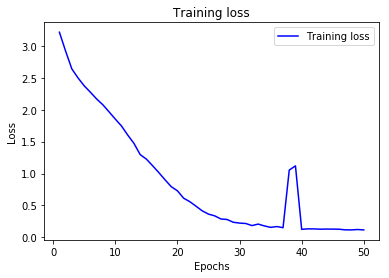

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b-', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Make a Decoder model

During training, we presented sequences of 30 characters, along with the correct next character.
When_using the trained model, it may be more useful to feed in 1 character at a time, and seeing the next
predicted one. That will also convince us that the network is actually _using_ its internal state.

- Needs input length of 1.
- Needs batch size of 1
- Needs LSTM to be stateful
- check that params is the same as model_train

<img src="figures/1-in-1-out.png" style="width: 600px;"/>

In [ ]:
# Load model if necessary.
# model_train = load_model("keras-startrek-LSTM-model.h5")

In [13]:
# Build a decoding model (input length 1, batch size 1, stateful)
layer_size = 128

model_dec = Sequential()
# 1 letter in, 1 letter out.
# Stateful=True keeps the state from the end of one batch to the start of the next
# In other words, the network "remembers" its state from one input to the next. This is essential when
# the network looks at 1 input at a time.
model_dec.add(LSTM(layer_size, stateful=True, batch_input_shape=(1,1,len(chars))))

# project back to vocabulary
model_dec.add(Dense(vocabulary_size, activation='softmax'))
model_dec.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
model_dec.summary()

# set weights from training model
# Note that we can reuse these weights, since the sizes of the trained and decoder network are the same.
# The trained network took in 30 characters, but remember that all these 30 used the same input weights.
# That is one of the advantages of RNNs: They are independent of sequence lengths.
model_dec.set_weights(model_train.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 128)                  91136     
_________________________________________________________________
dense_3 (Dense)              (1, 49)                   6321      
Total params: 97,457
Trainable params: 97,457
Non-trainable params: 0
_________________________________________________________________


## Test the Model

- Take a quote then add 400 characters.

In [17]:
# Sample 1000 characters from the decoding model using a random seed from the vocabulary.
generated = generate_text_segment(1000, diversity=2.0, generating_model = model_dec, input_sequence_length = 1)
sys.stdout.write(generated)
print()

 bleatter  hontcyes
ihanchonich
su
ecpait (pario
wemenseove pars of ancitiom
ermind starce
formtigm
menseon
chothe flinke
iquses frofe
thehelime
partyisticadian umengorss
blomhiswo
the worpl gemal ry of the kines
.fuer
the jlheposhes work plish
blobls
callors
endaghepceves
il fort sandss ligey
mhen
en
pleyalbll shinm fere
gusols ofsive whors
damegs. if omo
sourress
esu
iminateoustore of gighs of wiming
mpar of gemesis
comelrsinm
caresing of eng
gors if ofing
the artanceyes
cove reforss
dearcexigatay
enfever
the cloddatuges of shigren
cogherus chil tenpey
ex part ww
(part one
shodf ritlochord
pactior
desneceloke
vol
countify
ive
icue aronf, part i
etres of bathok
meionispicmad
the ligh ont herrrstorm
ighantigame's mins
des
thee shatlave
in t umen ence bafity
sedegaad
she qfhaw
w:ople rerkect f ce
shiderferqe
uwif caxl anfen pirstion

fuerino of and thers
seugry
fiort (partios
drrendirece, part ii
the recngs oft
the daecty
shime affrin
the parse
bamogs
dife
falipntyy of fachtlow
plith ar